In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412623,2013,1,regular,True,False,3878.0,2623,Missouri State,MVFC,fcs,17.0,NaN,2466,Northwestern State,Southland,fcs,23.0,NaN
4,332412230,2013,1,regular,True,True,3681.0,2230,Fordham,Patriot,fcs,51.0,NaN,227,Rhode Island,CAA,fcs,26.0,NaN


In [5]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        df_season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = df_games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            df_tmp = pd.DataFrame([val.to_dict() for val in data])
            if df_tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            df_tmp.columns = convert_to_snake_case(df_tmp.columns)

            df_tmp['clock_minutes'] = df_tmp['clock'].apply(lambda x: x['minutes'])
            df_tmp['clock_seconds'] = df_tmp['clock'].apply(lambda x: x['seconds'])
            df_tmp.drop(columns=['clock'], inplace=True)

            df_tmp = df_tmp[cols]
            season_dfs.append(df_tmp)
        
        df_season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        df_season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, df_tmp

    all_dfs.append(df_season_plays)

    del df_season_plays
    
df_plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [6]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [7]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


## 2. Join and Filter the Data

In [8]:
valid_plays = ['Pass Incompletion', 'Pass Completion', 'Rush',
       'Pass Interception', 'Safety', 'Sack', 'Pass Interception Return',
       'Pass Reception', 'Passing Touchdown', 'Rushing Touchdown',
       'Fumble Recovery (Opponent)', 'Fumble Recovery (Own)',
       'Fumble Return Touchdown', 
       'Interception Return Touchdown', 
       'Defensive 2pt Conversion',
       'Pass', 'Interception', 'Uncategorized']

fourth_down_plays = (
    df_plays
    .query('down==4 and play_type in @valid_plays')
    .reset_index(drop=True)
    .assign(
        rush=lambda x: np.where(x['play_text'].str.contains('rush', case=False) |
                                x['play_text'].str.contains('run', case=False) |
                                x['play_text'].str.contains('scramble', case=False) |
                                (x['play_type'] == 'Rush'), 1, 0),

        sack=lambda x: np.where((x['play_type'].str.contains('sack', case=False) | 
                                 x['play_text'].str.contains('sack', case=False)), 1, 0),
        pass_=lambda x: np.where(x['play_type'].str.contains('pass', case=False) |
                                 x['play_text'].str.contains('pass', case=False), 1, 0),
        interception=lambda x: np.where(x['play_text'].str.contains('intercept', case=False), 1, 0),
        kick=lambda x: np.where(x['play_text'].str.contains('kick', case=False), 1, 0),
        punt=lambda x: np.where(x['play_text'].str.contains('punt', case=False), 1, 0),
        field_goal=lambda x: np.where(x['play_text'].str.contains('field goal', case=False) |
                                      x['play_text'].str.contains('fg', case=False), 1, 0),
        kneel=lambda x: np.where(x['play_text'].str.contains('knee', case=False), 1, 0),
        penalty=lambda x: np.where(x['play_text'].str.contains('penalty', case=False), 1, 0),
        illegal_shift=lambda x: np.where(x['play_text'].str.contains('illegal shift', case=False), 1, 0),
        illegal_formation=lambda x: np.where(x['play_text'].str.contains('illegal formation', case=False), 1, 0),
        false_start=lambda x: np.where(x['play_text'].str.contains('false start', case=False), 1, 0),
        delay_of_game=lambda x: np.where(x['play_text'].str.contains('delay of game', case=False), 1, 0),
    )
    .query('punt==0 and kick==0 and field_goal==0 and kneel==0')
    .drop(columns=['punt','kick','field_goal','kneel'])
    .query('penalty==0 and illegal_shift==0 and illegal_formation==0 and false_start==0 and delay_of_game==0')
    .drop(columns=['penalty','illegal_shift','illegal_formation','false_start','delay_of_game'])
    # drop the plays not categorized as pass, rush, sack, or interception -> not enough context around play type
    .query('~(pass_==0 and rush==0 and sack==0 and interception==0)')
    .reset_index(drop=True)
)

In [9]:
(
    fourth_down_plays.rush.value_counts(normalize=True), 
    fourth_down_plays.sack.value_counts(normalize=True),
    fourth_down_plays.pass_.value_counts(normalize=True),
    fourth_down_plays.interception.value_counts(normalize=True)
)

(rush
 0    0.508095
 1    0.491905
 Name: proportion, dtype: float64,
 sack
 0    0.960263
 1    0.039737
 Name: proportion, dtype: float64,
 pass_
 0    0.526764
 1    0.473236
 Name: proportion, dtype: float64,
 interception
 0    0.976664
 1    0.023336
 Name: proportion, dtype: float64)

In [10]:
fourth_down_plays['first_down'] = np.where(
    (fourth_down_plays['yards_gained'] >= fourth_down_plays['distance']) &
    (fourth_down_plays['interception'] == 0) &
    (fourth_down_plays['sack'] == 0)
    , 1
    , 0
)

In [11]:
# Merge games and plays data
game_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id', 
        'home_team','home_id','home_points', 
        'away_team','away_id', 'away_points']

id_cols = ['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number','season', 'week']

play_cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 
             'offense', 'offense_conference', 'offense_score', 
             'defense', 'defense_conference', 'defense_score', 
             'home', 'away',
             'period', 'offense_timeouts', 'defense_timeouts', 
             'yardline', 'yards_to_goal', 'down', 'distance',
             'yards_gained', 'play_type', 'play_text',
             'clock_minutes', 'clock_seconds', 'first_down']

elo_cols = ['season', 'week', 'division', 'team_id', 'elo']

weather_cols = ['id', 'game_indoors', 'temperature', 
       'precipitation', 'wind_speed', ]

df = (
    df_games[game_cols].merge(fourth_down_plays[play_cols], left_on='id', right_on='game_id', suffixes=('_game', ''))
    .drop(columns=['id_game'])
    .rename(columns={'id': 'play_id'})
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'division': 'home_division', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'division': 'away_division', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
    .merge(
        df_weather[weather_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left',
    )
)
df = (
    df
    .assign(
        game_indoors = df.game_indoors.fillna(False),
        temperature = df.temperature.fillna(int(df.temperature.mean())),
        wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
        precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean())))
    )
)
df = df[id_cols + [c for c in df.columns if c not in id_cols]]

# move first_down to the end
df = df[[c for c in df.columns if c != 'first_down'] + ['first_down']]
df.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_73860/2075020280.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,defense_conference,defense_score,home,away,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,play_type,play_text,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,game_indoors,temperature,precipitation,wind_speed,first_down
0,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Big South,10,Kent State,Liberty,3,2.0,2.0,64,36,4,3,-3,Rush,Colin Reardon rush for a loss of 3 yards to th...,4,21,fbs,1954.443118,fcs,1553.191164,False,82.0,0.0,3.4,0
1,332412309,33241230905,332412309035,5,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Big South,0,Kent State,Liberty,1,2.0,3.0,54,46,4,1,4,Rush,Trayion Durham rush for 4 yards to the Liber 4...,2,6,fbs,1954.443118,fcs,1553.191164,False,82.0,0.0,3.4,1
2,332412309,33241230920,332412309178,20,6,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,17,Liberty,Big South,10,Kent State,Liberty,4,0.0,0.0,33,67,4,17,-3,Rush,Team rush for a loss of 3 yards to the KntSt 30.,0,3,fbs,1954.443118,fcs,1553.191164,False,82.0,0.0,3.4,0
3,332412309,33241230919,332412309172,19,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Liberty,Big South,10,Kent State,Mid-American,17,Kent State,Liberty,4,1.0,1.0,40,40,4,5,0,Pass Incompletion,Josh Woodrum pass incomplete to Darrin Peterso...,1,35,fbs,1954.443118,fcs,1553.191164,False,82.0,0.0,3.4,0
4,332412579,33241257903,332412579030,3,10,2013,1,regular,True,False,3994.0,South Carolina,2579,27.0,North Carolina,153,10.0,South Carolina,SEC,7,North Carolina,ACC,0,South Carolina,North Carolina,1,2.0,3.0,70,30,4,2,8,Rush,Brandon Wilds rush for 8 yards to the NCaro 22...,6,3,fbs,3035.188373,fbs,2475.527442,False,93.9,0.0,0.0,1


In [12]:
# Filter out overtime plays
df = df.query('period <= 4')

# Game must be completed
df = df.query('completed == True')

In [13]:
df.isna().sum()

game_id                 0
drive_id                0
play_id                 0
drive_number            0
play_number             0
season                  0
week                    0
season_type             0
completed               0
neutral_site            0
venue_id              105
home_team               0
home_id                 0
home_points             0
away_team               0
away_id                 0
away_points             0
offense                 0
offense_conference    115
offense_score           0
defense                 0
defense_conference     79
defense_score           0
home                    0
away                    0
period                  0
offense_timeouts        0
defense_timeouts        0
yardline                0
yards_to_goal           0
down                    0
distance                0
yards_gained            0
play_type               0
play_text              89
clock_minutes           0
clock_seconds           0
home_division           0
home_pregame

## 3. Feature Engineering

In [14]:
df = df.assign(
    pct_game_played = (((df['period'] - 1) * 15 * 60) + ((15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))) / (4 * 15 * 60),
    score_diff = df['offense_score'] - df['defense_score'],
    is_home_team = np.select([df.neutral_site, df.offense == df.home], [0, 1], default=-1),
    pregame_elo_diff = np.where(df['offense'] == df['home'], df['home_pregame_elo'] - df['away_pregame_elo'], df['away_pregame_elo'] - df['home_pregame_elo']),
    pregame_offense_elo = np.where(df['offense'] == df['home'], df['home_pregame_elo'], df['away_pregame_elo']),
    pregame_defense_elo = np.where(df['offense'] == df['home'], df['away_pregame_elo'], df['home_pregame_elo']),
    offense_division = np.where(df['offense'] == df['home'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home'], df['away_division'], df['home_division']),
)

df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,defense_conference,defense_score,home,away,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,play_type,play_text,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,game_indoors,temperature,precipitation,wind_speed,first_down,pct_game_played,score_diff,is_home_team,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_division,defense_division
0,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Big South,10,Kent State,Liberty,3,2.0,2.0,64,36,4,3,-3,Rush,Colin Reardon rush for a loss of 3 yards to th...,4,21,fbs,1954.443118,fcs,1553.191164,False,82.0,0.0,3.4,0,0.677500,-3,1,401.251954,1954.443118,1553.191164,fbs,fcs
1,332412309,33241230905,332412309035,5,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Big South,0,Kent State,Liberty,1,2.0,3.0,54,46,4,1,4,Rush,Trayion Durham rush for 4 yards to the Liber 4...,2,6,fbs,1954.443118,fcs,1553.191164,False,82.0,0.0,3.4,1,0.215000,7,1,401.251954,1954.443118,1553.191164,fbs,fcs
2,332412309,33241230920,332412309178,20,6,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,17,Liberty,Big South,10,Kent State,Liberty,4,0.0,0.0,33,67,4,17,-3,Rush,Team rush for a loss of 3 yards to the KntSt 30.,0,3,fbs,1954.443118,fcs,1553.191164,False,82.0,0.0,3.4,0,0.999167,7,1,401.251954,1954.443118,1553.191164,fbs,fcs
3,332412309,33241230919,332412309172,19,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Liberty,Big South,10,Kent State,Mid-American,17,Kent State,Liberty,4,1.0,1.0,40,40,4,5,0,Pass Incompletion,Josh Woodrum pass incomplete to Darrin Peterso...,1,35,fbs,1954.443118,fcs,1553.191164,False,82.0,0.0,3.4,0,0.973611,-7,-1,-401.251954,1553.191164,1954.443118,fcs,fbs
4,332412579,33241257903,332412579030,3,10,2013,1,regular,True,False,3994.0,South Carolina,2579,27.0,North Carolina,153,10.0,South Carolina,SEC,7,North Carolina,ACC,0,South Carolina,North Carolina,1,2.0,3.0,70,30,4,2,8,Rush,Brandon Wilds rush for 8 yards to the NCaro 22...,6,3,fbs,3035.188373,fbs,2475.527442,False,93.9,0.0,0.0,1,0.149167,7,1,559.660931,3035.188373,2475.527442,fbs,fbs


In [15]:
df.columns

Index(['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number',
       'season', 'week', 'season_type', 'completed', 'neutral_site',
       'venue_id', 'home_team', 'home_id', 'home_points', 'away_team',
       'away_id', 'away_points', 'offense', 'offense_conference',
       'offense_score', 'defense', 'defense_conference', 'defense_score',
       'home', 'away', 'period', 'offense_timeouts', 'defense_timeouts',
       'yardline', 'yards_to_goal', 'down', 'distance', 'yards_gained',
       'play_type', 'play_text', 'clock_minutes', 'clock_seconds',
       'home_division', 'home_pregame_elo', 'away_division',
       'away_pregame_elo', 'game_indoors', 'temperature', 'precipitation',
       'wind_speed', 'first_down', 'pct_game_played', 'score_diff',
       'is_home_team', 'pregame_elo_diff', 'pregame_offense_elo',
       'pregame_defense_elo', 'offense_division', 'defense_division'],
      dtype='object')

## 4. Final Data

In [16]:
cols = ['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number',
       'season', 'week', 'season_type',
       'offense', 'defense',
       'offense_timeouts', 'defense_timeouts',
       'yards_to_goal', 'down', 'distance', 'yards_gained',
       'play_type', 'play_text',
       'game_indoors', 'temperature', 'precipitation',
       'wind_speed', 'pct_game_played', 'score_diff',
       'is_home_team', 'pregame_elo_diff', 'pregame_offense_elo',
       'pregame_defense_elo', 'first_down']

#TODO: remove filtering for FBS only?
df = df.query('offense_division == "fbs" or defense_division == "fbs"')[cols].reset_index(drop=True)
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,offense,defense,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,yards_gained,play_type,play_text,game_indoors,temperature,precipitation,wind_speed,pct_game_played,score_diff,is_home_team,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,first_down
0,332412309,33241230914,332412309118,14,10,2013,1,regular,Kent State,Liberty,2.0,2.0,36,4,3,-3,Rush,Colin Reardon rush for a loss of 3 yards to th...,False,82.0,0.0,3.4,0.677500,-3,1,401.251954,1954.443118,1553.191164,0
1,332412309,33241230905,332412309035,5,5,2013,1,regular,Kent State,Liberty,2.0,3.0,46,4,1,4,Rush,Trayion Durham rush for 4 yards to the Liber 4...,False,82.0,0.0,3.4,0.215000,7,1,401.251954,1954.443118,1553.191164,1
2,332412309,33241230920,332412309178,20,6,2013,1,regular,Kent State,Liberty,0.0,0.0,67,4,17,-3,Rush,Team rush for a loss of 3 yards to the KntSt 30.,False,82.0,0.0,3.4,0.999167,7,1,401.251954,1954.443118,1553.191164,0
3,332412309,33241230919,332412309172,19,9,2013,1,regular,Liberty,Kent State,1.0,1.0,40,4,5,0,Pass Incompletion,Josh Woodrum pass incomplete to Darrin Peterso...,False,82.0,0.0,3.4,0.973611,-7,-1,-401.251954,1553.191164,1954.443118,0
4,332412579,33241257903,332412579030,3,10,2013,1,regular,South Carolina,North Carolina,2.0,3.0,30,4,2,8,Rush,Brandon Wilds rush for 8 yards to the NCaro 22...,False,93.9,0.0,0.0,0.149167,7,1,559.660931,3035.188373,2475.527442,1


In [17]:
df.isna().sum()

game_id                 0
drive_id                0
play_id                 0
drive_number            0
play_number             0
season                  0
week                    0
season_type             0
offense                 0
defense                 0
offense_timeouts        0
defense_timeouts        0
yards_to_goal           0
down                    0
distance                0
yards_gained            0
play_type               0
play_text              31
game_indoors            0
temperature             0
precipitation           0
wind_speed              0
pct_game_played         0
score_diff              0
is_home_team            0
pregame_elo_diff        0
pregame_offense_elo     0
pregame_defense_elo     0
first_down              0
dtype: int64

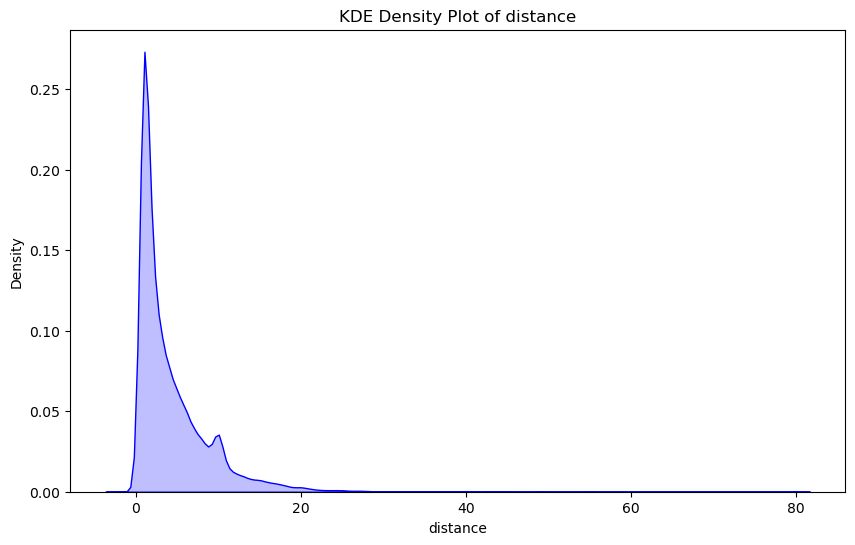

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.distance, fill=True, color='blue')
plt.title('KDE Density Plot of distance')
plt.xlabel('distance')
plt.ylabel('Density')
plt.show()

In [19]:
(
    df.query('100 >= yards_to_goal > 90').first_down.value_counts(normalize=True),
    df.query('90 >= yards_to_goal > 80').first_down.value_counts(normalize=True),
    df.query('80 >= yards_to_goal > 60').first_down.value_counts(normalize=True),
    df.query('60 >= yards_to_goal > 40').first_down.value_counts(normalize=True),
    df.query('40 >= yards_to_goal > 20').first_down.value_counts(normalize=True),
    df.query('20 >= yards_to_goal > 10').first_down.value_counts(normalize=True),
    df.query('10 >= yards_to_goal > 0').first_down.value_counts(normalize=True)
)

(first_down
 0    0.76087
 1    0.23913
 Name: proportion, dtype: float64,
 first_down
 0    0.656168
 1    0.343832
 Name: proportion, dtype: float64,
 first_down
 1    0.544121
 0    0.455879
 Name: proportion, dtype: float64,
 first_down
 1    0.540281
 0    0.459719
 Name: proportion, dtype: float64,
 first_down
 0    0.505595
 1    0.494405
 Name: proportion, dtype: float64,
 first_down
 0    0.504322
 1    0.495678
 Name: proportion, dtype: float64,
 first_down
 0    0.657658
 1    0.342342
 Name: proportion, dtype: float64)

## 5. Make the model

In [20]:
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,offense,defense,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,yards_gained,play_type,play_text,game_indoors,temperature,precipitation,wind_speed,pct_game_played,score_diff,is_home_team,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,first_down
0,332412309,33241230914,332412309118,14,10,2013,1,regular,Kent State,Liberty,2.0,2.0,36,4,3,-3,Rush,Colin Reardon rush for a loss of 3 yards to th...,False,82.0,0.0,3.4,0.677500,-3,1,401.251954,1954.443118,1553.191164,0
1,332412309,33241230905,332412309035,5,5,2013,1,regular,Kent State,Liberty,2.0,3.0,46,4,1,4,Rush,Trayion Durham rush for 4 yards to the Liber 4...,False,82.0,0.0,3.4,0.215000,7,1,401.251954,1954.443118,1553.191164,1
2,332412309,33241230920,332412309178,20,6,2013,1,regular,Kent State,Liberty,0.0,0.0,67,4,17,-3,Rush,Team rush for a loss of 3 yards to the KntSt 30.,False,82.0,0.0,3.4,0.999167,7,1,401.251954,1954.443118,1553.191164,0
3,332412309,33241230919,332412309172,19,9,2013,1,regular,Liberty,Kent State,1.0,1.0,40,4,5,0,Pass Incompletion,Josh Woodrum pass incomplete to Darrin Peterso...,False,82.0,0.0,3.4,0.973611,-7,-1,-401.251954,1553.191164,1954.443118,0
4,332412579,33241257903,332412579030,3,10,2013,1,regular,South Carolina,North Carolina,2.0,3.0,30,4,2,8,Rush,Brandon Wilds rush for 8 yards to the NCaro 22...,False,93.9,0.0,0.0,0.149167,7,1,559.660931,3035.188373,2475.527442,1


In [21]:
data = df[['game_id','drive_id','play_id','distance','score_diff','pregame_elo_diff','pct_game_played','is_home_team',
           'precipitation', 'wind_speed', 'temperature', 'yards_to_goal',
           'first_down']]

# Split into 80-20 train val set by game_id
game_ids = df.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)].drop(columns=['drive_id','play_id'])

In [22]:
data.head()

,game_id,drive_id,play_id,distance,score_diff,pregame_elo_diff,pct_game_played,is_home_team,precipitation,wind_speed,temperature,yards_to_goal,first_down
0,332412309,33241230914,332412309118,3,-3,401.251954,0.677500,1,0.0,3.4,82.0,36,0
1,332412309,33241230905,332412309035,1,7,401.251954,0.215000,1,0.0,3.4,82.0,46,1
2,332412309,33241230920,332412309178,17,7,401.251954,0.999167,1,0.0,3.4,82.0,67,0
3,332412309,33241230919,332412309172,5,-7,-401.251954,0.973611,-1,0.0,3.4,82.0,40,0
4,332412579,33241257903,332412579030,2,7,559.660931,0.149167,1,0.0,0.0,93.9,30,1


In [23]:
# model_dir = os.path.join(DATA_DIR, 'models', 'fourth_down')

# model_files = [f for f in os.listdir(model_dir) if f.endswith('.json')]

# models = []
# for model_file in model_files:
#     model_path = os.path.join(model_dir, model_file)
#     model = xgb.Booster()  # Create an empty Booster object
#     model.load_model(model_path)  # Load the model from the json file
#     models.append(model)

# print(f"Loaded {len(models)} models from the '{model_dir}' folder.")

In [24]:
data.isna().sum()

game_id             0
drive_id            0
play_id             0
distance            0
score_diff          0
pregame_elo_diff    0
pct_game_played     0
is_home_team        0
precipitation       0
wind_speed          0
temperature         0
yards_to_goal       0
first_down          0
dtype: int64

In [25]:
data.dtypes

game_id               int64
drive_id             object
play_id              object
distance              int64
score_diff            int64
pregame_elo_diff    float64
pct_game_played     float64
is_home_team          int64
precipitation       float64
wind_speed          float64
temperature         float64
yards_to_goal         int64
first_down            int64
dtype: object

In [26]:
data.shape

(31796, 13)

In [27]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 2
np.random.seed(SEED)

N_BOOTSTRAP = 100
    
feature_names = data_train.drop(columns=['game_id','drive_id','play_id','first_down']).columns.tolist()
monotonic_constraints_map = {
    "score_diff": 1,
    "pregame_elo_diff": 1,
    "is_home_team": 1,
    "precipitation": -1,
    "wind_speed": -1,
    "distance": -1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Bootstrapping
models = []
for i in tqdm(range(N_BOOTSTRAP), desc='Bootstrapping'):
    # Bootstrap sampling
    game_ids = data_train.game_id.unique()
    game_ids_sample = np.random.choice(game_ids, size=len(game_ids), replace=True)
    train_data = data_train[data_train.game_id.isin(game_ids_sample)]

    # Only keep one play per drive
    train_data = train_data.sample(frac=1, random_state=SEED).reset_index(drop=True)
    train_data = train_data.drop_duplicates(subset=['game_id', 'drive_id'], keep='first')

    # Split into 80-20 train-val set by game_id
    game_ids_train, game_ids_valid = train_test_split(train_data.game_id.unique(), test_size=0.2, random_state=SEED)
    train = train_data[train_data.game_id.isin(game_ids_train)]
    valid = train_data[train_data.game_id.isin(game_ids_valid)]
    train_x = train.drop(columns=['game_id', 'drive_id', 'play_id', 'first_down'])
    train_y = train['first_down']
    valid_x = valid.drop(columns=['game_id', 'drive_id', 'play_id', 'first_down'])
    valid_y = valid['first_down']
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    study = optuna.create_study(
        study_name="conversion_probability_hyperopt", 
        direction="minimize", 
        load_if_exists=True
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

    # Train a model with the best params
    best_params = {
        **study.best_trial.params,
        'nthread': -1,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'monotone_constraints': monotonic_constraints,
        'eval_metric': 'logloss',
        'seed': SEED,
    }
    bst = xgb.train(
        best_params, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    models.append(bst)

Bootstrapping: 100%|██████████| 100/100 [07:53<00:00,  4.73s/it]


Calculating SHAP values: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


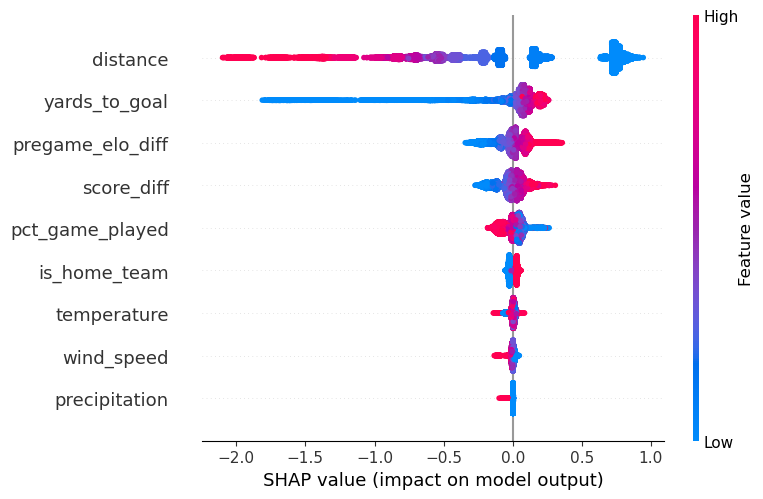

In [38]:
all_shap_values = []

background = data_train.drop(columns=['game_id', 'drive_id', 'play_id', 'first_down'])

for model in tqdm(models, desc='Calculating SHAP values'):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(background)
    all_shap_values.append(shap_vals)

shap_values_array = np.stack(all_shap_values)  # shape: (n_models, n_samples, n_features)
mean_shap_values = np.mean(shap_values_array, axis=0)  # shape: (n_samples, n_features)

shap.summary_plot(mean_shap_values, background)

Calculating Feature Importance: 100%|██████████| 100/100 [00:00<00:00, 3068.05it/s]


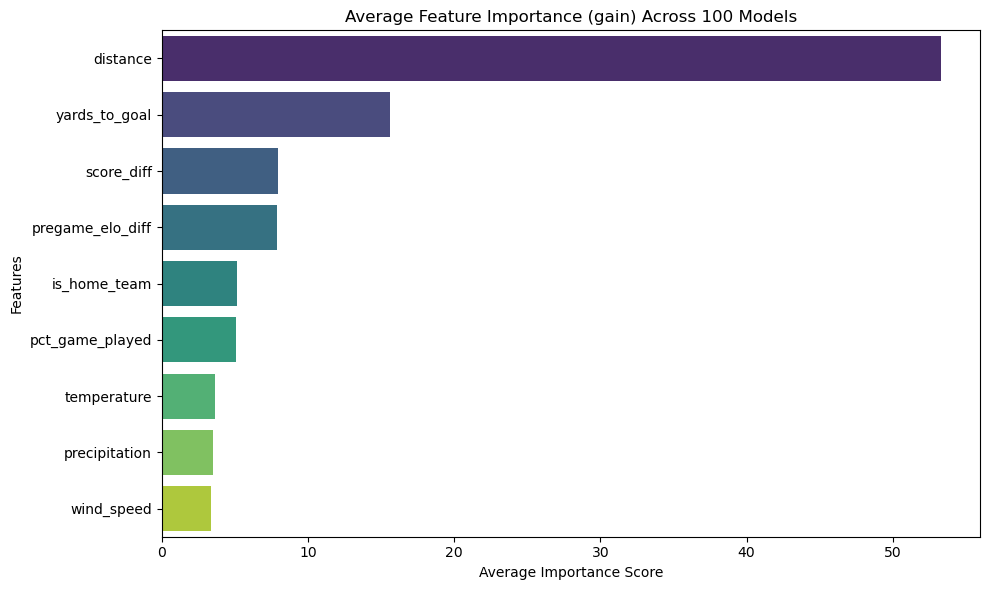

In [29]:
def plot_aggregated_feature_importance(models, importance_type="gain"):
    total_importance = {}

    # Aggregate importances across all models
    for model in tqdm(models, desc='Calculating Feature Importance'):
        importance = model.get_score(importance_type=importance_type)
        for feat, score in importance.items():
            total_importance[feat] = total_importance.get(feat, 0) + score

    # Average the importance by number of models
    for feat in total_importance:
        total_importance[feat] /= len(models)

    importance_df = pd.DataFrame({
        "Feature": list(total_importance.keys()),
        "Importance": list(total_importance.values())
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance", 
        y="Feature", 
        data=importance_df, 
        palette="viridis", 
        hue="Feature", 
        dodge=False
    )
    plt.title(f"Average Feature Importance ({importance_type}) Across {len(models)} Models")
    plt.xlabel("Average Importance Score")
    plt.ylabel("Features")
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()

plot_aggregated_feature_importance(models, importance_type="gain") # gain, weight, cover

Average Test Log Loss over 100 models: 0.61998


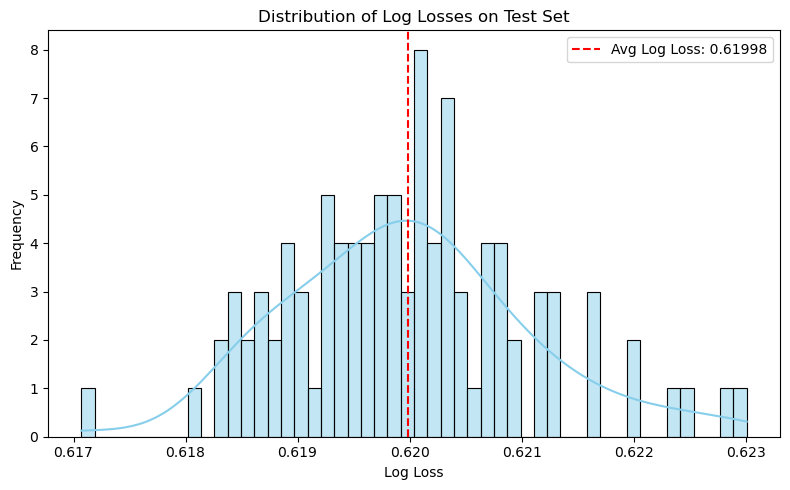

In [30]:
test_x = data_test.drop(columns=['game_id', 'first_down'])
test_y = data_test['first_down'].values.ravel()
dtest = xgb.DMatrix(test_x)

loglosses = []

for model in models:
    preds = model.predict(dtest)
    loss = log_loss(test_y, preds)
    loglosses.append(loss)

avg_logloss = np.mean(loglosses)
print(f"Average Test Log Loss over {len(models)} models: {avg_logloss:.5f}")

plt.figure(figsize=(8, 5))
sns.histplot(loglosses, bins=50, kde=True, color="skyblue")
plt.axvline(avg_logloss, color="red", linestyle="--", label=f"Avg Log Loss: {avg_logloss:.5f}")
plt.title("Distribution of Log Losses on Test Set")
plt.xlabel("Log Loss")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
data_all = data.drop(columns=['game_id', 'drive_id', 'play_id', 'first_down'])
dall = xgb.DMatrix(data_all)

preds_all_models = []

for model in models:
    preds = model.predict(dall)
    preds_all_models.append(preds)

preds_all_models = np.array(preds_all_models)

# Calculate the 5%, 50%, 95% percentiles and the mean for each sample
df['conversion_proba_5'] = np.percentile(preds_all_models, 5, axis=0)
df['conversion_proba_50'] = np.percentile(preds_all_models, 50, axis=0)
df['conversion_proba_95'] = np.percentile(preds_all_models, 95, axis=0)
df['conversion_proba_mean'] = np.mean(preds_all_models, axis=0)

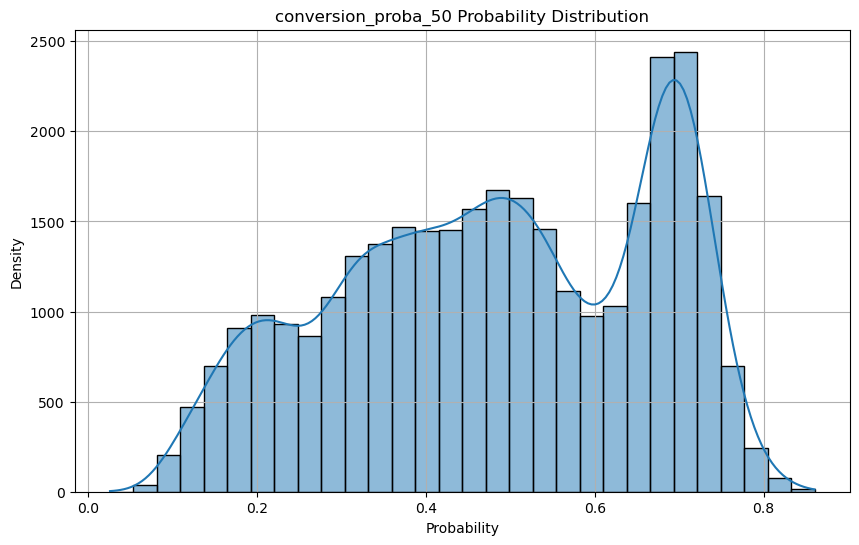

In [32]:
# plot win probability
def plot_wp(df, col='conversion_proba_50'):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df, col='conversion_proba_50')

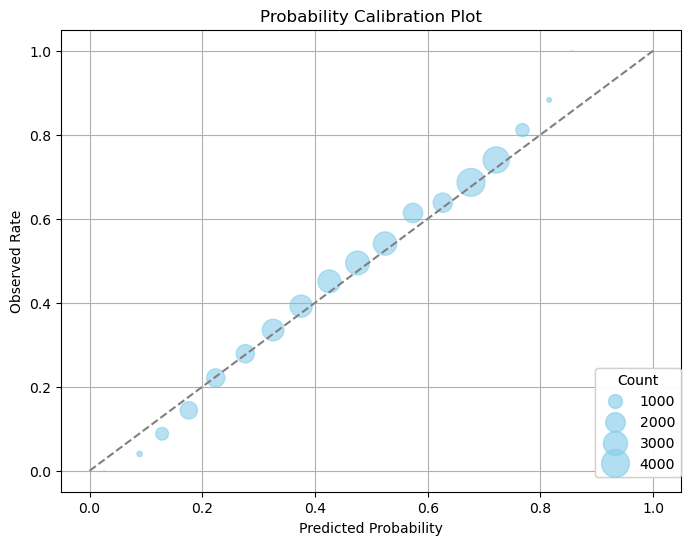

In [33]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        calibration['predicted_proba'], 
        calibration['actual_proba'], 
        s=calibration['count'] * scale,
        alpha=0.6, 
        label='Calibration Curve',
        color='skyblue',
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()

    # Add legend for dot size reference
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda x: x / scale,
                                              color='skyblue')
    labels = [int(re.search(r'\{(\d+)\}', value).group(1)) for value in labels]
    legend = plt.legend(handles, labels, title="Count", loc="center left", bbox_to_anchor=(.85, 0.15))
    plt.gca().add_artist(legend)

    plt.show()

plot_calibration(df, proba_col='conversion_proba_50', actual_col='first_down', bins=20, scale=0.1)

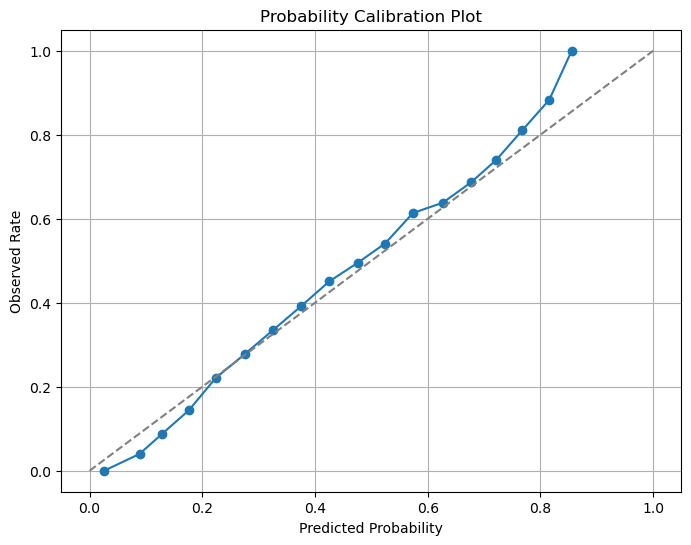

In [34]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(df, proba_col='conversion_proba_50', actual_col='first_down', bins=20)

In [35]:
df[data.columns.tolist() + ['conversion_proba_5','conversion_proba_50','conversion_proba_95']].sort_values(by='conversion_proba_50', ascending=True).head(20)

,game_id,drive_id,play_id,distance,score_diff,pregame_elo_diff,pct_game_played,is_home_team,precipitation,wind_speed,temperature,yards_to_goal,first_down,conversion_proba_5,conversion_proba_50,conversion_proba_95
21743,401309592,-1824,-14160,17,-29,-626.917039,0.558889,1,0.000,13.7,44.6,0,0,0.013163,0.025840,0.047527
22754,401426545,-2543,-19848,7,-35,-877.455017,0.738889,1,0.012,3.4,73.8,0,0,0.031678,0.053878,0.086848
28865,401645321,40164532119,401645321104976301,26,-40,-1415.328293,0.956667,-1,0.000,6.9,86.4,35,0,0.034836,0.067058,0.098038
26334,401525501,40152550120,401525501103919901,21,-34,-1689.896618,0.616667,-1,0.000,5.8,68.7,39,0,0.038316,0.067107,0.108730
12594,401019481,40101948123,401019481104865903,21,-38,-1458.881047,0.772222,-1,0.004,2.4,78.8,34,0,0.043096,0.070464,0.099184
12431,401012249,40101224926,401012249104997003,21,-47,-841.633024,0.991944,-1,0.000,9.2,87.4,35,0,0.043842,0.070688,0.103415
9233,400869160,40086916024,400869160104965101,25,-35,-417.625938,0.936667,-1,0.000,13.9,52.0,25,0,0.045870,0.070718,0.106411
4704,400548320,40054832023,400548320104997201,28,-28,-1021.327985,0.992500,1,0.000,3.4,39.2,35,0,0.033169,0.070781,0.108442
14314,401013171,40101317123,401013171104935401,20,-29,-515.316068,0.887500,-1,0.000,5.5,27.3,22,0,0.050238,0.074035,0.109052
2627,400547916,40054791624,400547916104987206,27,-18,-944.658014,0.975833,-1,0.110,10.3,71.1,32,0,0.045911,0.074826,0.108747


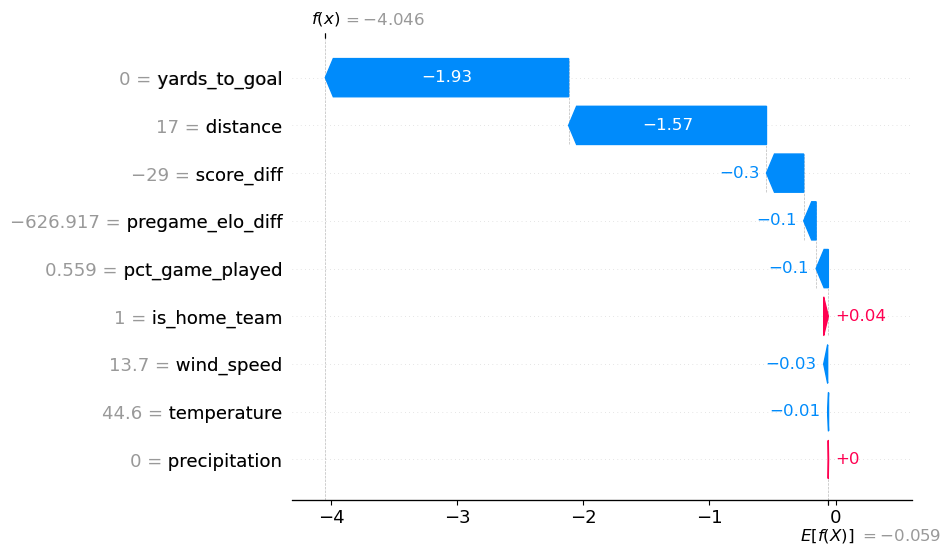

In [36]:
idx = 21743

model = models[0]

game_data = data[data.index == idx].drop(columns=['game_id', 'drive_id', 'play_id', 'first_down']).head(1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

In [37]:
model_dir = join(DATA_DIR, 'models', 'fourth_down')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for i, model in enumerate(models):
    model_path = os.path.join(model_dir, f"model_{i}.json")
    model.save_model(model_path)

print(f"Saved {len(models)} models to the '{model_dir}' folder.")

Saved 100 models to the '../data/models/fourth_down' folder.
